#**파일불러오기**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install autogluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 27.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Insta

In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import missingno as msnco

%matplotlib inline
# Any results you write to the current directory are saved as output.
import random
import os

from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.core as ag

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

In [ ]:
# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print('Device:', device)
# print('Current cuda device:', torch.cuda.current_device())
# print('Count of using GPUs:', torch.cuda.device_count())

In [41]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(69) 

pd.set_option('mode.chained_assignment',  None)

In [42]:
train_df = pd.read_csv('/content/drive/MyDrive/airline/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/airline/test.csv')

#**비행시간구하기**

# **state별 시차 계산**

In [43]:
train_df = train_df[train_df['Estimated_Arrival_Time'] > train_df['Estimated_Departure_Time']]

In [44]:
def find_time_lag(train_df, state):
    OA = train_df[train_df['Origin_State'] == state]
    predict_st = OA.Destination_State.unique().tolist()
    DA = train_df[train_df['Destination_State'] == state]
    time_delay_dict = {}
    for st in predict_st:
        st_oa = OA[OA['Destination_State'] == st]
        st_oa_diff = st_oa.Estimated_Arrival_Time.mean() - st_oa.Estimated_Departure_Time.mean()
        st_da = DA[DA['Origin_State'] == st]
        st_da_diff = st_da.Estimated_Arrival_Time.mean() - st_da.Estimated_Departure_Time.mean()
        time_delay = st_da_diff - st_oa_diff
        if not np.isnan(time_delay):
            time_delay_dict[state, st] = -round(time_delay/2/60)
    
    return time_delay_dict

time_delay = dict()
for i in train_df['Origin_State'].unique().tolist():
    time_delay.update(find_time_lag(train_df, i))
    
s = pd.DataFrame(time_delay, index=['time_delay']).T
s.unstack()

time_delay                 \
                                                  Alabama Alaska Arizona   
Alabama                                               NaN    NaN     NaN   
Alaska                                                NaN    0.0     2.0   
Arizona                                               NaN   -2.0     0.0   
Arkansas                                              NaN    NaN    -2.0   
California                                            NaN   -2.0     1.0   
Colorado                                              1.0   -3.0    -1.0   
Connecticut                                           NaN    NaN     NaN   
Florida                                              -2.0    NaN    -4.0   
Georgia                                              -2.0    NaN    -4.0   
Hawaii                                                NaN    2.0     4.0   
Idaho                                                 NaN    NaN    -1.0   
Illinois                                              0.0    NaN    -2.0   
Indiana                                               NaN    NaN    -4.0   
Iowa                                                  NaN    NaN    -2.0   
Kansas                                                NaN    NaN    -3.0   
Kentucky                                              NaN    NaN    -4.0   
Louisiana                                             NaN    NaN    -2.0   
Maine                                                 NaN    NaN     NaN   
Maryland                                             -1.0    NaN    -4.0   
Massachusetts                                         NaN    NaN    -3.0   
Michigan                                             -2.0    NaN    -4.0   
Minnesota                                             NaN   -4.0    -2.0   
Mississippi                                           NaN    NaN     NaN   
Missouri                                              NaN    NaN    -2.0   
Montana                                               NaN    NaN    -1.0   
Nebraska                                              NaN    NaN    -2.0   
Nevada                                                3.0    NaN     1.0   
New Hampshire                                         NaN    NaN     NaN   
New Jersey                                            NaN    NaN    -4.0   
New Mexico                                            NaN    NaN    -1.0   
New York                                             -1.0    NaN    -4.0   
North Carolina                                       -2.0    NaN    -4.0   
North Dakota                                          NaN    NaN    -2.0   
Ohio                                                  NaN    NaN    -4.0   
Oklahoma                                              NaN    NaN    -2.0   
Oregon                                                NaN   -2.0     0.0   
Pennsylvania                                         -2.0    NaN    -4.0   
Puerto Rico                                           NaN    NaN     NaN   
Rhode Island                                          NaN    NaN     NaN   
South Carolina                                        NaN    NaN     NaN   
South Dakota                                          NaN    NaN    -2.0   
Tennessee                                             NaN    NaN    -2.0   
Texas                                                 0.0    NaN    -2.0   
U.S. Pacific Trust Territories and Possessions        NaN    NaN     NaN   
U.S. Virgin Islands                                   NaN    NaN     NaN   
Utah                                                  NaN   -3.0    -1.0   
Vermont                                               NaN    NaN     NaN   
Virginia                                             -2.0    NaN    -4.0   
Washington                                            NaN   -2.0     0.0   
West Virginia                                         NaN    NaN     NaN   
Wisconsin                                             NaN    NaN    -2.0   
Wyoming            

# **state 시간대별 category화**

In [45]:
time_delay = dict()
for i in train_df['Origin_State'].unique().tolist():
    time_delay.update(find_time_lag(train_df, i))

s = pd.DataFrame(time_delay, index=['time_delay']).T
s.reset_index(inplace=True)
s = s.where(s['time_delay']==0)
s = s.dropna()
ars = s['level_0'].to_list()
ders= s['level_1'].to_list()

def check_list(ls, ar):
    check_in_list = False
    check_idx = 0
    for i in range(len(ls)):
        for j in ls[i]:
            if ar in j:
                return True, i
    return False, -1

ls = [set()]
for ar, der in zip(ars,ders):
    for i in ls:
        if check_list(ls, ar)[0]:
            ls[check_list(ls, ar)[1]].add(der)
        else:
            ls.append(set([ar, der]))

ls.pop(0)
print(ls) #7

[{'Louisiana', 'Wisconsin', 'Illinois', 'Tennessee', 'Missouri', 'Oklahoma', 'Texas', 'Arkansas', 'Minnesota', 'Nebraska', 'Mississippi', 'Alabama', 'North Dakota', 'Kansas', 'Iowa', 'Utah', 'South Dakota'}, {'Georgia', 'Massachusetts', 'West Virginia', 'Vermont', 'Indiana', 'U.S. Virgin Islands', 'Ohio', 'Maine', 'Kentucky', 'Michigan', 'Florida', 'North Carolina', 'Pennsylvania', 'Rhode Island', 'New Hampshire', 'Maryland', 'New York', 'Puerto Rico', 'South Carolina', 'Connecticut', 'Virginia', 'New Jersey'}, {'Arizona', 'California', 'Nevada', 'Washington', 'Oregon'}, {'Oregon', 'Arizona', 'Washington'}, {'Idaho', 'Colorado', 'Wyoming', 'Montana', 'Utah', 'New Mexico', 'South Dakota'}, {'Alaska'}, {'Hawaii'}, {'U.S. Pacific Trust Territories and Possessions'}]


#**출발 예정 시간, 도착 예정 시간 결측치 채우기**
##**train, test 모두 적용해줘야함**

In [46]:
def calculate_time_lag(row, time_delay_dict):
    origin_state = row['Origin_State']
    destination_state = row['Destination_State']
    if (origin_state, destination_state) in time_delay_dict:
        return time_delay_dict[(origin_state, destination_state)]
    else:
        return 0

# (출발지 이름, 도착지 이름)을 key로 하는 딕셔너리 생성
time_delay_dict = {(origin, dest): -delay for (origin, dest), delay in time_delay.items()}
train_df['time_leg'] = train_df.apply(lambda row: calculate_time_lag(row, time_delay_dict), axis=1) #시차 입력해둔 컬럼

# 각 행마다 비행 소요 시간을 계산
def calculate_flight_duration_with_time_lag(row, time_delay_dict, s):
    origin_state = row['Origin_State']
    destination_state = row['Destination_State']
    dep_time = row['Estimated_Departure_Time']
    arr_time = row['Estimated_Arrival_Time']
    
    # 시간을 분 단위로 변환
    dep_minutes = dep_time // 100 * 60 + dep_time % 100
    arr_minutes = arr_time // 100 * 60 + arr_time % 100
    
    flight_duration = arr_minutes - dep_minutes
    
    if (origin_state, destination_state) in time_delay_dict:
        time_lag = time_delay_dict[(origin_state, destination_state)]
        flight_duration += time_lag
        
    if (origin_state, destination_state) in s:
        time_lag = s[(origin_state, destination_state)]
        flight_duration += time_lag
    
    return flight_duration

train_df['Flight_Duration_Before'] = train_df.apply(calculate_flight_duration_with_time_lag, args=(time_delay_dict, s), axis=1)
train_df['Flight_Duration_hhrr'] = train_df['Flight_Duration_Before'].apply(lambda x: '{0}h{1:02d}m'.format(int(x/60), int(x%60)))

train_df['time_leg'] *= 60  #1->60분으로 계산  
duration = train_df['Flight_Duration_Before'] + train_df['time_leg']  # 비행 소요 시간 계산

def convert_duration(duration):
    hours = int(duration / 60)
    minutes = int(duration % 60)
    return f"{hours}h{minutes:02d}m"

train_df['Flight_Duration_After'] = duration.apply(convert_duration)
train_df['Flight_Duration_After_hhmm'] = duration

flight_duration_df = train_df
train_df = pd.read_csv('/content/drive/MyDrive/airline/train.csv')

flight_duration_df = flight_duration_df[['ID', 'time_leg','Flight_Duration_After','Flight_Duration_After_hhmm']]
new_train_df = pd.merge(train_df, flight_duration_df, on='ID', how='left')


train_df = new_train_df


train_df['Flight_Duration_mean'] = train_df.groupby(['Origin_Airport', 'Destination_Airport'])['Flight_Duration_After_hhmm'].transform('mean')
train_df

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,time_leg,Flight_Duration_After,Flight_Duration_After_hhmm,Flight_Duration_mean
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,...,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN,NaN,NaN,NaN,85.490798
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,...,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN,60.0,3h45m,225.0,207.755102
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,...,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN,0.0,1h55m,115.0,118.941057
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,...,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN,-240.0,4h26m,266.0,302.383747
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,...,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN,0.0,1h19m,79.0,80.824818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,0,0,ORD,13930,NaN,...,678.0,United Air Lines Inc.,UA,19977.0,N477UA,NaN,0.0,3h07m,187.0,133.567686
999996,TRAIN_999996,5,30,920.0,1028.0,0,0,FAR,11637,NaN,...,223.0,SkyWest Airlines Inc.,DL,NaN,N439SW,NaN,0.0,1h08m,68.0,72.037383
999997,TRAIN_999997,6,28,800.0,1340.0,0,0,OAK,13796,NaN,...,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,NaN,0.0,5h40m,340.0,205.770115
999998,TRAIN_999998,9,27,1613.0,1824.0,0,0,BNA,10693,Tennessee,...,214.0,Delta Air Lines Inc.,DL,19790.0,N968DL,NaN,0.0,2h11m,131.0,82.119512


In [16]:
# # #평균값구하기
# train_df[(train_df['Origin_State']=='Tennessee') & (train_df['Destination_State']=='Illinois')]['Flight_Duration_After_hhmm'].mean()


93.02660016625104

In [47]:
train_df = train_df.drop(['Cancelled', 'Diverted'], axis=1)
train_df

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,time_leg,Flight_Duration_After,Flight_Duration_After_hhmm,Flight_Duration_mean
0,TRAIN_000000,4,15,NaN,NaN,OKC,13851,Oklahoma,HOU,12191,...,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN,NaN,NaN,NaN,85.490798
1,TRAIN_000001,8,15,740.0,1024.0,ORD,13930,Illinois,SLC,14869,...,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN,60.0,3h45m,225.0,207.755102
2,TRAIN_000002,9,6,1610.0,1805.0,CLT,11057,North Carolina,LGA,12953,...,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN,0.0,1h55m,115.0,118.941057
3,TRAIN_000003,7,10,905.0,1735.0,LAX,12892,California,EWR,11618,...,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN,-240.0,4h26m,266.0,302.383747
4,TRAIN_000004,1,11,900.0,1019.0,SFO,14771,California,ACV,10157,...,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN,0.0,1h19m,79.0,80.824818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,936.0,1243.0,ORD,13930,NaN,PHL,14100,...,678.0,United Air Lines Inc.,UA,19977.0,N477UA,NaN,0.0,3h07m,187.0,133.567686
999996,TRAIN_999996,5,30,920.0,1028.0,FAR,11637,NaN,MSP,13487,...,223.0,SkyWest Airlines Inc.,DL,NaN,N439SW,NaN,0.0,1h08m,68.0,72.037383
999997,TRAIN_999997,6,28,800.0,1340.0,OAK,13796,NaN,HOU,12191,...,1642.0,Southwest Airlines Co.,WN,19393.0,N230WN,NaN,0.0,5h40m,340.0,205.770115
999998,TRAIN_999998,9,27,1613.0,1824.0,BNA,10693,Tennessee,ATL,10397,...,214.0,Delta Air Lines Inc.,DL,19790.0,N968DL,NaN,0.0,2h11m,131.0,82.119512


In [48]:
#Not_delayed라벨링이 붙은 데이터들의 평균 비행소요시간
undelayed = train_df[train_df['Delay']=='Not_Delayed']
train_df['undelayed_Duration_mean'] = undelayed.groupby(['Origin_Airport', 'Destination_Airport'])['Flight_Duration_After_hhmm'].transform('mean')

In [49]:
#Delayed 라벨링이 붙은 데이터들의 평균 비행소요시간
delayed = train_df[train_df['Delay']=='Delayed']
train_df['delayed_Duration_mean'] = delayed.groupby(['Origin_Airport', 'Destination_Airport'])['Flight_Duration_After_hhmm'].transform('mean')
train_df.head(30)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,time_leg,Flight_Duration_After,Flight_Duration_After_hhmm,Flight_Duration_mean,undelayed_Duration_mean,delayed_Duration_mean
0,TRAIN_000000,4,15,NaN,NaN,OKC,13851,Oklahoma,HOU,12191,...,WN,19393.0,N7858A,NaN,NaN,NaN,NaN,85.490798,NaN,NaN
1,TRAIN_000001,8,15,740.0,1024.0,ORD,13930,Illinois,SLC,14869,...,UA,20304.0,N125SY,NaN,60.0,3h45m,225.0,207.755102,NaN,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,CLT,11057,North Carolina,LGA,12953,...,AA,19805.0,N103US,NaN,0.0,1h55m,115.0,118.941057,NaN,NaN
3,TRAIN_000003,7,10,905.0,1735.0,LAX,12892,California,EWR,11618,...,UA,NaN,N595UA,NaN,-240.0,4h26m,266.0,302.383747,NaN,NaN
4,TRAIN_000004,1,11,900.0,1019.0,SFO,14771,California,ACV,10157,...,UA,20304.0,N161SY,NaN,0.0,1h19m,79.0,80.824818,NaN,NaN
5,TRAIN_000005,4,13,1545.0,NaN,EWR,11618,NaN,DCA,11278,...,UA,20452.0,N657RW,Not_Delayed,NaN,NaN,NaN,81.641115,81.921569,NaN
6,TRAIN_000006,1,20,1742.0,1903.0,EWR,11618,New Jersey,BOS,10721,...,UA,NaN,N66825,Not_Delayed,0.0,1h21m,81.0,73.295292,72.955224,NaN
7,TRAIN_000007,4,20,1815.0,1955.0,ORD,13930,Illinois,MCI,13198,...,UA,20304.0,N110SY,NaN,0.0,1h40m,100.0,95.470588,NaN,NaN
8,TRAIN_000008,6,13,1420.0,1550.0,BWI,10821,NaN,CLT,11057,...,WN,19393.0,N765SW,Not_Delayed,0.0,1h30m,90.0,95.569863,96.388235,NaN
9,TRAIN_000009,6,6,650.0,838.0,LIT,12992,Arkansas,IAH,12266,...,UA,20366.0,N14902,NaN,0.0,1h48m,108.0,95.484444,NaN,NaN


In [14]:
train_df[train_df['Origin_State']=='New York'].head(30)

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,time_leg,Flight_Duration_After,Flight_Duration_After_hhmm,Flight_Duration_mean,undelayed_Duration_mean,delayed_Duration_mean
22,TRAIN_000022,3,6,1030.0,1150.0,BUF,10792,New York,IAD,12264,...,UA,20046.0,N421ZW,NaN,0.0,1h20m,80.0,88.483649,NaN,NaN
26,TRAIN_000026,8,26,644.0,805.0,BUF,10792,New York,BOS,10721,...,B6,20409.0,N306JB,NaN,0.0,1h21m,81.0,80.099741,NaN,NaN
66,TRAIN_000066,6,21,1141.0,NaN,JFK,12478,New York,HYA,12250,...,B6,20409.0,N273JB,NaN,NaN,NaN,NaN,80.099741,NaN,NaN
70,TRAIN_000070,9,3,1311.0,1507.0,LGA,12953,New York,DAY,11267,...,AA,NaN,N258PS,NaN,0.0,1h56m,116.0,116.759725,NaN,NaN
71,TRAIN_000071,2,6,1650.0,NaN,ISP,12391,New York,BWI,10821,...,WN,19393.0,N454WN,NaN,NaN,NaN,NaN,74.922857,NaN,NaN
82,TRAIN_000082,8,31,1330.0,1454.0,ROC,14576,New York,PHL,14100,...,AA,20427.0,N624AE,NaN,0.0,1h24m,84.0,85.401274,NaN,NaN
86,TRAIN_000086,6,29,655.0,730.0,BUF,10792,New York,MDW,13232,...,WN,19393.0,N8671D,NaN,0.0,0h35m,35.0,NaN,NaN,NaN
87,TRAIN_000087,8,19,1330.0,1558.0,JFK,12478,New York,PHX,14107,...,AA,19805.0,N907AN,NaN,240.0,6h32m,392.0,419.924107,NaN,NaN
96,TRAIN_000096,12,8,1655.0,2002.0,LGA,12953,New York,MCO,13204,...,DL,19790.0,N371NW,Not_Delayed,0.0,3h07m,187.0,182.664581,182.580160,NaN
155,TRAIN_000155,7,14,2029.0,NaN,LGA,12953,New York,PIT,14122,...,AA,20452.0,N109HQ,Not_Delayed,NaN,NaN,NaN,85.401274,85.154867,NaN


In [64]:
a = train_df[(train_df['Origin_State']=='New York') & (train_df['Destination_State']=='Florida')]
# A = a[a['Delay']=='Not_Delayed']
a = a[(a['Origin_Airport']=='LGA') & (a['Destination_Airport']=='MCO') & (a['Carrier_Code(IATA)']=='DL')]
a['diff'] = a['Flight_Duration_After_hhmm']-a['Flight_Duration_mean']
a[['Estimated_Departure_Time',	'Estimated_Arrival_Time',	'Origin_State', 'Origin_Airport', 'Destination_State','Destination_Airport','Distance','Carrier_Code(IATA)','Delay','time_leg','Flight_Duration_After','Flight_Duration_After_hhmm','Flight_Duration_mean','delayed_Duration_mean','undelayed_Duration_mean','diff']].head(50)


,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_State,Origin_Airport,Destination_State,Destination_Airport,Distance,Carrier_Code(IATA),Delay,time_leg,Flight_Duration_After,Flight_Duration_After_hhmm,Flight_Duration_mean,delayed_Duration_mean,undelayed_Duration_mean,diff
96,1655.0,2002.0,New York,LGA,Florida,MCO,950.0,DL,Not_Delayed,0.0,3h07m,187.0,176.937304,NaN,178.811594,10.062696
3061,NaN,1503.0,New York,LGA,Florida,MCO,950.0,DL,Not_Delayed,NaN,NaN,NaN,176.937304,NaN,178.811594,NaN
4327,805.0,1109.0,New York,LGA,Florida,MCO,950.0,DL,NaN,0.0,3h04m,184.0,176.937304,NaN,NaN,7.062696
13761,1232.0,1533.0,New York,LGA,Florida,MCO,950.0,DL,NaN,0.0,3h01m,181.0,176.937304,NaN,NaN,4.062696
20428,NaN,2121.0,New York,LGA,Florida,MCO,950.0,DL,NaN,NaN,NaN,NaN,176.937304,NaN,NaN,NaN
23148,805.0,1051.0,New York,LGA,Florida,MCO,950.0,DL,Not_Delayed,0.0,2h46m,166.0,176.937304,NaN,178.811594,-10.937304
24473,710.0,951.0,New York,LGA,Florida,MCO,950.0,DL,NaN,0.0,2h41m,161.0,176.937304,NaN,NaN,-15.937304
42060,1735.0,2032.0,New York,LGA,Florida,MCO,950.0,DL,NaN,0.0,2h57m,177.0,176.937304,NaN,NaN,0.062696
44326,1429.0,NaN,New York,LGA,Florida,MCO,950.0,DL,Delayed,NaN,NaN,NaN,176.937304,178.454545,NaN,NaN
48484,933.0,1222.0,New York,LGA,Florida,MCO,950.0,DL,NaN,0.0,2h49m,169.0,176.937304,NaN,NaN,-7.937304


In [23]:
a = train_df[(train_df['Origin_State']=='New York') & (train_df['Destination_State']=='Florida')]
# A = a[a['Delay']=='Not_Delayed']
a[(a['Origin_Airport']=='LGA') & (a['Destination_Airport']=='MCO') & (a['Carrier_Code(IATA)']=='DL') & (a['Delay']=='Delayed')].head(30)


,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,...,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay,time_leg,Flight_Duration_After,Flight_Duration_After_hhmm,Flight_Duration_mean,undelayed_Duration_mean,delayed_Duration_mean
44326,TRAIN_044326,5,17,1429.0,NaN,LGA,12953,New York,MCO,13204,...,DL,19790.0,N369DN,Delayed,NaN,NaN,NaN,182.664581,NaN,184.227437
475234,TRAIN_475234,1,7,NaN,1229.0,LGA,12953,New York,MCO,13204,...,DL,19790.0,N3744F,Delayed,NaN,NaN,NaN,182.664581,NaN,184.227437
709168,TRAIN_709168,11,13,NaN,NaN,LGA,12953,New York,MCO,13204,...,DL,19790.0,N301DV,Delayed,NaN,NaN,NaN,182.664581,NaN,184.227437
758707,TRAIN_758707,1,8,NaN,2027.0,LGA,12953,New York,MCO,13204,...,DL,19790.0,N375NC,Delayed,NaN,NaN,NaN,182.664581,NaN,184.227437


In [22]:
train_df[(train_df['Origin_State']=='New York') & (train_df['Destination_State']=='Florida')]['Distance'].unique()

array([ 950., 1175., 1076., 1138., 1197., 1069., 1035., 1005.,  828.,
       1029., 1096., 1262.,  971., 1186., 1010.,  944., 1028.,  972.,
       1041., 1053., 1204., 1074., 1033., 1166., 1056., 1011., 1034.,
        989., 1089.,  833., 1102., 1092.,  954.,  891., 1047., 1073.,
       1080., 1129., 1118., 1130., 1052., 1097., 1224., 1101., 1032.,
        996., 1144., 1185., 1079., 1055., 1009., 1111., 1334., 1176.,
       1104.,  965., 1077., 1143., 1142., 1113., 1205., 1311., 1164.,
        897., 1049., 1090.,  874.])

#**TEST_DF에도** 적용해주기

In [13]:
test_df = test_df[test_df['Estimated_Arrival_Time'] > test_df['Estimated_Departure_Time']]

In [31]:
def find_time_lag(test_df, state):
    OA = test_df[test_df['Origin_State'] == state]
    predict_st = OA.Destination_State.unique().tolist()
    DA = test_df[test_df['Destination_State'] == state]
    time_delay_dict = {}
    for st in predict_st:
        st_oa = OA[OA['Destination_State'] == st]
        st_oa_diff = st_oa.Estimated_Arrival_Time.mean() - st_oa.Estimated_Departure_Time.mean()
        st_da = DA[DA['Origin_State'] == st]
        st_da_diff = st_da.Estimated_Arrival_Time.mean() - st_da.Estimated_Departure_Time.mean()
        time_delay = st_da_diff - st_oa_diff
        if not np.isnan(time_delay):
            time_delay_dict[state, st] = -round(time_delay/2/60)
    
    return time_delay_dict

time_delay = dict()
for i in test_df['Origin_State'].unique().tolist():
    time_delay.update(find_time_lag(train_df, i))
    
s = pd.DataFrame(time_delay, index=['time_delay']).T
s.unstack()

time_delay                 \
                                                  Alabama Alaska Arizona   
Alabama                                               NaN    NaN     NaN   
Alaska                                                NaN    0.0   -10.0   
Arizona                                               NaN   10.0     0.0   
Arkansas                                              NaN    NaN     0.0   
California                                            NaN    0.0     0.0   
Colorado                                              1.0   15.0    -1.0   
Connecticut                                           NaN    NaN     NaN   
Florida                                              -1.0    NaN    -3.0   
Georgia                                              -2.0   14.0    -3.0   
Hawaii                                                NaN  -15.0   -10.0   
Idaho                                                 NaN    NaN    -2.0   
Illinois                                              0.0   15.0    -1.0   
Indiana                                               NaN    NaN     3.0   
Iowa                                                  NaN    NaN    -2.0   
Kansas                                                NaN    NaN    -2.0   
Kentucky                                              NaN    NaN    -3.0   
Louisiana                                             NaN    NaN    -1.0   
Maine                                                 NaN    NaN     NaN   
Maryland                                             -2.0    NaN     0.0   
Massachusetts                                         NaN    NaN     6.0   
Michigan                                             -2.0    NaN    -1.0   
Minnesota                                             NaN   10.0    -1.0   
Mississippi                                           NaN    NaN     NaN   
Missouri                                              NaN    NaN    -1.0   
Montana                                               NaN    NaN    -1.0   
Nebraska                                              NaN    NaN    -1.0   
Nevada                                               -1.0    NaN     0.0   
New Hampshire                                         NaN    NaN     NaN   
New Jersey                                            NaN   14.0     0.0   
New Mexico                                            NaN    NaN     0.0   
New York                                             -1.0    NaN     2.0   
North Carolina                                       -2.0    NaN    -2.0   
North Dakota                                          NaN    NaN    -3.0   
Ohio                                                  NaN    NaN    -3.0   
Oklahoma                                              NaN    NaN    -2.0   
Oregon                                                NaN   -1.0     1.0   
Pennsylvania                                         -1.0    NaN    -1.0   
Puerto Rico                                           NaN    NaN     NaN   
Rhode Island                                          NaN    NaN     NaN   
South Carolina                                        NaN    NaN     NaN   
South Dakota                                          NaN    NaN    -2.0   
Tennessee                                             NaN    NaN     0.0   
Texas                                                 0.0   15.0    -2.0   
U.S. Pacific Trust Territories and Possessions        NaN    NaN     NaN   
U.S. Virgin Islands                                   NaN    NaN     NaN   
Utah                                                  NaN   -3.0    -1.0   
Vermont                                               NaN    NaN     NaN   
Virginia                                             -1.0    NaN     1.0   
Washington                                            NaN   -3.0     1.0   
West Virginia                                         NaN    NaN     NaN   
Wisconsin                                             NaN    NaN     0.0   
Wyoming            

In [32]:
time_delay = dict()
for i in test_df['Origin_State'].unique().tolist():
    time_delay.update(find_time_lag(test_df, i))

s = pd.DataFrame(time_delay, index=['time_delay']).T
s.reset_index(inplace=True)
s = s.where(s['time_delay']==0)
s = s.dropna()
ars = s['level_0'].to_list()
ders= s['level_1'].to_list()

def check_list(ls, ar):
    check_in_list = False
    check_idx = 0
    for i in range(len(ls)):
        for j in ls[i]:
            if ar in j:
                return True, i
    return False, -1

ls = [set()]
for ar, der in zip(ars,ders):
    for i in ls:
        if check_list(ls, ar)[0]:
            ls[check_list(ls, ar)[1]].add(der)
        else:
            ls.append(set([ar, der]))

ls.pop(0)
print(ls) #7

[{'New York', 'Maryland', 'Massachusetts', 'Pennsylvania', 'North Carolina', 'Rhode Island', 'South Carolina', 'Ohio', 'Puerto Rico', 'Indiana', 'U.S. Virgin Islands', 'Vermont', 'Florida', 'Maine', 'Kentucky', 'Virginia', 'New Hampshire', 'West Virginia', 'Connecticut', 'Michigan', 'New Jersey', 'Georgia'}, {'Oklahoma', 'North Dakota', 'Tennessee', 'Utah', 'Missouri', 'Alabama', 'Illinois', 'Arkansas', 'Kansas', 'Minnesota', 'Iowa', 'Wisconsin', 'Texas', 'Nebraska', 'Louisiana', 'Mississippi', 'South Dakota'}, {'Arizona', 'California', 'Nevada', 'Washington', 'Oregon'}, {'Oregon', 'Washington', 'Arizona'}, {'Utah', 'Idaho', 'Wyoming', 'Montana', 'Colorado', 'South Dakota', 'New Mexico'}, {'Hawaii'}, {'Alaska'}, {'U.S. Pacific Trust Territories and Possessions'}]


In [33]:
def calculate_time_lag(row, time_delay_dict):
    origin_state = row['Origin_State']
    destination_state = row['Destination_State']
    if (origin_state, destination_state) in time_delay_dict:
        return time_delay_dict[(origin_state, destination_state)]
    else:
        return 0

# (출발지 이름, 도착지 이름)을 key로 하는 딕셔너리 생성
time_delay_dict = {(origin, dest): -delay for (origin, dest), delay in time_delay.items()}
test_df['time_leg'] = test_df.apply(lambda row: calculate_time_lag(row, time_delay_dict), axis=1) #시차 입력해둔 컬럼

# 각 행마다 비행 소요 시간을 계산
def calculate_flight_duration_with_time_lag(row, time_delay_dict, s):
    origin_state = row['Origin_State']
    destination_state = row['Destination_State']
    dep_time = row['Estimated_Departure_Time']
    arr_time = row['Estimated_Arrival_Time']
    
    # 시간을 분 단위로 변환
    dep_minutes = dep_time // 100 * 60 + dep_time % 100
    arr_minutes = arr_time // 100 * 60 + arr_time % 100
    
    flight_duration = arr_minutes - dep_minutes
    
    if (origin_state, destination_state) in time_delay_dict:
        time_lag = time_delay_dict[(origin_state, destination_state)]
        flight_duration += time_lag
        
    if (origin_state, destination_state) in s:
        time_lag = s[(origin_state, destination_state)]
        flight_duration += time_lag
    
    return flight_duration

test_df['Flight_Duration_Before'] = test_df.apply(calculate_flight_duration_with_time_lag, args=(time_delay_dict, s), axis=1)
test_df['Flight_Duration_hhrr'] = test_df['Flight_Duration_Before'].apply(lambda x: '{0}h{1:02d}m'.format(int(x/60), int(x%60)))

test_df['time_leg'] *= 60  #1->60분으로 계산  
duration = test_df['Flight_Duration_Before'] + test_df['time_leg']  # 비행 소요 시간 계산

def convert_duration(duration):
    hours = int(duration / 60)
    minutes = int(duration % 60)
    return f"{hours}h{minutes:02d}m"

test_df['Flight_Duration_After'] = duration.apply(convert_duration)
test_df['Flight_Duration_After_hhmm'] = duration

flight_duration_df = test_df
test_df = pd.read_csv('/content/drive/MyDrive/airline/test.csv')

flight_duration_df = flight_duration_df[['ID', 'time_leg','Flight_Duration_After','Flight_Duration_After_hhmm']]
new_test_df = pd.merge(test_df, flight_duration_df, on='ID', how='left')


test_df = new_test_df

test_df['Flight_Duration_mean'] = test_df.groupby(['Origin_State', 'Destination_State'])['Flight_Duration_After_hhmm'].transform('mean')
test_df

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,...,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,time_leg,Flight_Duration_After,Flight_Duration_After_hhmm,Flight_Duration_mean
0,TEST_000000,12,16,1156.0,NaN,0,0,IAH,12266,Texas,...,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402,NaN,NaN,NaN,73.195290
1,TEST_000001,9,12,1500.0,1715.0,0,0,EWR,11618,New Jersey,...,NaN,746.0,Delta Air Lines Inc.,DL,19790.0,N3765,0.0,2h15m,135.0,NaN
2,TEST_000002,3,6,1600.0,1915.0,0,0,ORD,13930,Illinois,...,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA,-60.0,2h14m,134.0,122.319493
3,TEST_000003,5,18,1920.0,2045.0,0,0,OAK,13796,California,...,California,337.0,Southwest Airlines Co.,WN,19393.0,N905WN,0.0,1h25m,85.0,82.409404
4,TEST_000004,7,7,1915.0,2152.0,0,0,FLL,11697,Florida,...,California,2343.0,JetBlue Airways,B6,20409.0,N945JT,240.0,6h41m,401.0,407.586552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TEST_999995,6,2,NaN,2240.0,0,0,LAX,12892,California,...,Colorado,862.0,Southwest Airlines Co.,WN,19393.0,N720WN,NaN,NaN,NaN,81.964140
999996,TEST_999996,6,8,600.0,648.0,0,0,BUF,10792,New York,...,Illinois,473.0,United Air Lines Inc.,UA,19977.0,N401UA,60.0,1h49m,109.0,150.387762
999997,TEST_999997,6,11,1710.0,1907.0,0,0,IAD,12264,NaN,...,Michigan,383.0,Mesa Airlines Inc.,UA,20378.0,N510MJ,0.0,1h57m,117.0,NaN
999998,TEST_999998,11,17,NaN,500.0,0,0,SAN,14679,California,...,Massachusetts,2588.0,JetBlue Airways,B6,20409.0,N986JB,NaN,NaN,NaN,273.219895


#**Airline 결측치 채우기**

In [34]:
train_df_drop = train_df.dropna().copy()

In [35]:
airline_values = train_df_drop.Airline.unique()
airline_keys = train_df_drop['Carrier_ID(DOT)'].unique()
airline_dict = dict(zip(airline_keys, airline_values))

In [36]:
s = train_df[train_df['Airline'].isna() & ~train_df['Carrier_ID(DOT)'].isna()]
t = train_df[train_df['Carrier_ID(DOT)'].isna() & ~train_df['Airline'].isna()]
test_s = test_df[test_df['Airline'].isna() & ~test_df['Carrier_ID(DOT)'].isna()]


In [37]:
train_df['Airline'][train_df['Airline'].isna() & ~train_df['Carrier_ID(DOT)'].isna()] = s['Carrier_ID(DOT)'].map(airline_dict)
test_df['Airline'][test_df['Airline'].isna() & ~test_df['Carrier_ID(DOT)'].isna()] = test_s['Carrier_ID(DOT)'].map(airline_dict)

#train_df['Carrier_ID(DOT)'][train_df['Carrier_ID(DOT)'].isna() & ~train_df['Airline'].isna()] = t['Airline']

#**필요없는 컬럼 drop**

In [38]:
train_df_drop.drop(['Carrier_ID(DOT)', 'Tail_Number'], axis=1, inplace=True)

In [39]:
test_df.drop(['Carrier_ID(DOT)', 'Tail_Number'], axis=1, inplace=True)

In [40]:
train_df.isna().sum()

ID                                 0
Month                              0
Day_of_Month                       0
Estimated_Departure_Time      109019
Estimated_Arrival_Time        109040
Origin_Airport_ID                  0
Origin_State                  109015
Destination_Airport_ID             0
Destination_State             109079
Distance                           0
Airline                       108920
Carrier_Code(IATA)            108990
Carrier_ID(DOT)               108997
Tail_Number                        0
Delay                         744999
time_leg                      233543
Flight_Duration_After         233543
Flight_Duration_After_hhmm    233543
Flight_Duration_mean          206854
undelayed_Duration_mean       833489
delayed_Duration_mean         964294
dtype: int64

In [41]:
test_df.isna().sum()

ID                                 0
Month                              0
Day_of_Month                       0
Estimated_Departure_Time      108984
Estimated_Arrival_Time        109048
Cancelled                          0
Diverted                           0
Origin_Airport                     0
Origin_Airport_ID                  0
Origin_State                  106505
Destination_Airport                0
Destination_Airport_ID             0
Destination_State             106523
Distance                           0
Airline                       106527
Carrier_Code(IATA)            108993
time_leg                      236347
Flight_Duration_After         236347
Flight_Duration_After_hhmm    236347
Flight_Duration_mean          160490
dtype: int64

#**Delay : 1, Not_Delayed: 0**

In [42]:
map_dic = {'Not_Delayed' : 0, 'Delayed' : 1}
train_df_drop['Delay'] = train_df_drop['Delay'].map(map_dic)

In [ ]:
# #0-2400 0부터 24로 시간순서대로 indexing
# def arr_time(x):
#     a= [i for i in range(600,2401,100)]
#     a[-1] = 2401
#     if x < a[0]:
#         return str((a[0] - 100)//100)
#     for i in range(len(a)-1):
#         if x >= a[i] and x < a[i+1]:
#             return str(a[i]//100)

In [ ]:
# train_df['Estimated_Departure_Time'] = train_df['Estimated_Departure_Time'].astype('int')
# train_df['Departure_Block'] = train_df['Estimated_Departure_Time'].apply(lambda x: arr_time(x))

#..Year컬럼 필요한가...?

In [43]:
train_df_drop['Year'] = train_df_drop['Month']*100+ train_df_drop['Day_of_Month']
test_df['Year'] = test_df['Month']*100 + test_df['Day_of_Month']

#**모델링 전, 필요한컬럼들만!**

In [45]:
final_df = train_df_drop[['Estimated_Departure_Time', 'Estimated_Arrival_Time','Origin_Airport_ID','Destination_Airport_ID','Distance','Airline','Delay','time_leg','Flight_Duration_After' ]].reset_index(drop=True)
test_final_df = test_df[['Estimated_Departure_Time', 'Estimated_Arrival_Time','Origin_Airport_ID','Destination_Airport_ID','Distance','Airline','time_leg','Flight_Duration_After']].reset_index(drop=True)

In [46]:
test_df.isna().sum()

ID                                 0
Month                              0
Day_of_Month                       0
Estimated_Departure_Time      108984
Estimated_Arrival_Time        109048
Cancelled                          0
Diverted                           0
Origin_Airport                     0
Origin_Airport_ID                  0
Origin_State                  106505
Destination_Airport                0
Destination_Airport_ID             0
Destination_State             106523
Distance                           0
Airline                       106527
Carrier_Code(IATA)            108993
time_leg                      236347
Flight_Duration_After         236347
Flight_Duration_After_hhmm    236347
Flight_Duration_mean          160490
Year                               0
dtype: int64

#**AutoGluon 사용**

In [47]:
label = 'Delay'
eval_metric = 'f1_macro'
time_limit = 3600*2

In [49]:
predictor = TabularPredictor(
    label=label, problem_type='binary', eval_metric=eval_metric
).fit(final_df, 
      presets='best_quality',
      num_stack_levels=3,
      #excluded_model_types = excluded_model_types,
      time_limit=time_limit, num_gpus=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20230426_182655/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=5, num_bag_sets=20


ZeroDivisionError: ignored

In [ ]:
predictor = TabularPredictor.load("/content/AutogluonModels/ag-20230424_043520")

In [ ]:
predictor.leaderboard(final_df, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,0.926958,0.518990,0.971186,0.642001,0.186560,0.971186,0.642001,0.186560,1,True,2
1,WeightedEnsemble_L2,0.926958,0.518990,0.976046,0.889915,116.807017,0.004860,0.247915,116.620457,2,True,14
2,RandomForestEntr_BAG_L1,0.902830,0.515261,21.330105,7.032230,87.231764,21.330105,7.032230,87.231764,1,True,6
3,RandomForestGini_BAG_L1,0.886231,0.517551,15.874070,6.829103,78.511774,15.874070,6.829103,78.511774,1,True,5
4,ExtraTreesGini_BAG_L1,0.685863,0.489058,16.500573,6.887095,26.877357,16.500573,6.887095,26.877357,1,True,8
5,ExtraTreesEntr_BAG_L1,0.605506,0.475113,9.984614,5.427917,25.903156,9.984614,5.427917,25.903156,1,True,9
6,KNeighborsUnif_BAG_L1,0.603976,0.500411,0.639128,1.052460,0.292858,0.639128,1.052460,0.292858,1,True,1
7,LightGBMXT_BAG_L4,0.560332,0.521789,595.651442,207.233633,6000.894622,10.907257,2.767580,62.411996,4,True,33
8,LightGBM_BAG_L3,0.559876,0.536937,480.728498,168.350676,5015.121582,278.174924,93.377573,666.576321,3,True,26
9,WeightedEnsemble_L4,0.559876,0.536937,480.733179,168.577594,5077.306421,0.004681,0.226918,62.184839,4,True,32


In [ ]:
predictor.feature_importance(final_df)

Computing feature importance via permutation shuffling for 6 features using 5000 rows with 5 shuffle sets...
	1910.64s	= Expected runtime (382.13s per shuffle set)
	1061.3s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Destination_Airport,0.105716,0.013678,0.000033,5,0.133878,0.077553
Origin_Airport,0.103066,0.011897,0.000021,5,0.127562,0.078570
Estimated_Departure_Time,0.092980,0.009533,0.000013,5,0.112609,0.073351
Estimated_Arrival_Time,0.091484,0.014011,0.000064,5,0.120332,0.062636
Airline,0.085411,0.011346,0.000036,5,0.108771,0.062050
Distance,0.079413,0.010086,0.000031,5,0.100180,0.058647


In [ ]:
test_data = TabularDataset(test_final_df)

y_pred = predictor.predict_proba(test_data)
y_pred.head()

,0,1
0,0.991073,0.008927
1,0.879538,0.120462
2,0.844774,0.155226
3,0.746049,0.253951
4,0.869526,0.130474


In [ ]:
sub_csv = pd.read_csv('/content/drive/MyDrive/airline/TEST_667053.csv')

In [ ]:
sub_csv['Not_Delayed'] = y_pred[0]
sub_csv['Delayed'] = y_pred[1]

In [ ]:
sub_csv

,ID,Not_Delayed,Delayed
0,TEST_667053,0.991073,0.008927
1,TEST_667054,0.879538,0.120462
2,TEST_667055,0.844774,0.155226
3,TEST_667056,0.746049,0.253951
4,TEST_667057,0.869526,0.130474
...,...,...,...
332942,TEST_999995,NaN,NaN
332943,TEST_999996,NaN,NaN
332944,TEST_999997,NaN,NaN
332945,TEST_999998,NaN,NaN


In [ ]:
sub_csv.to_csv('/content/drive/MyDrive/airline/TEST_667053_baseline_submission.csv', index=False)

<Axes: >

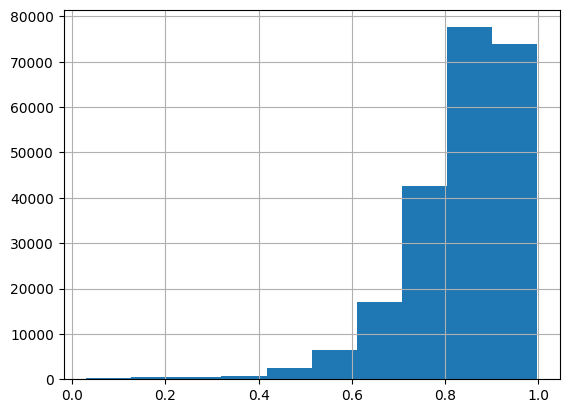

In [ ]:
sub_csv['Not_Delayed'].hist(bins=10)

In [ ]:
sub_csv['Not_Delayed'] = sub_csv[]